In [549]:
import pandas as pd
import numpy as np
#sklearn doesn't automatically import subpackages but for formality I've included it in the module imports declaration section
import sklearn 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


import opendatasets 
import matplotlib.pyplot as plt
import datetime

import joblib

In [140]:
#Downloads the dataset to the current folder
import opendatasets 
ccfd_dataset_url = "https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv"
opendatasets.download(ccfd_dataset_url)

Skipping, found downloaded files in ".\fraud-detection" (use force=True to force download)


In [141]:
transactions = pd.read_csv("./fraud-detection/fraudTrain.csv")
transactions.describe()

KeyboardInterrupt: 

In [ ]:
#Performs feature selection, engineering and extraction
def process_features(df: pd.DataFrame)->pd.DataFrame:
    new_df = df.drop(columns=["Unnamed: 0", "cc_num", "city", "street", "state", "zip", "trans_num"], axis=1)
    #Generate age and drop dob
    current_year = datetime.datetime.now().year
    new_df["age"]= new_df["dob"].apply(lambda x: current_year - int(x.split("-")[0]))
    new_df = new_df.drop(columns=["dob"], axis=1)
    #Remove the weird fraud_ thing that comes before a merchants name and rename merchant to merch_name
    new_df["merchant"] = new_df["merchant"].apply(lambda x: x.split("fraud_")[1]) 
    new_df = new_df.rename(columns={"merchant":"merch_name"})
    #Combine first and last name into full name then drop the them
    new_df["full_name"] = new_df["first"]+" "+new_df["last"] 
    new_df = new_df.drop(columns=["first", "last"], axis=1)
    #Drop unix time
    new_df = new_df.drop(columns=["unix_time"], axis=1)
    datetime_format = "%Y-%m-%d %H:%M:%S"
    new_df["dow"] = new_df["trans_date_trans_time"].apply(lambda x: datetime.datetime.strptime(x, datetime_format).weekday())
    new_df["dom"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[2].split(" ")[0]))
    new_df["month"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[1]))
    new_df["year"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[0]))
    def process_time(time:str)->float:
        times = time.split(" ")[1].split(":")
        time_float = float(times[0])+float(times[1])/60
        return time_float
        #time_int = round(time_float)
        #return time_int if time_int <=24 else 0
        #return float(times[0])+float(times[1])/60+float(times[2])/3600
    new_df["time"] = new_df["trans_date_trans_time"].apply(process_time)
    new_df.drop(columns=["trans_date_trans_time"], axis=1)
    #time_labels = ['00:00-02:00', '02:00-04:00', '04:00-06:00', '06:00-08:00', '08:00-10:00', '10:00-12:00', '12:00-14:00', '14:00-16:00', '16:00-18:00', '18:00-20:00', '20:00-22:00', '22:00-24:00']
    #amt_labels = ['1-5000', '5001-10000', '10001-15000', '15001-20000', '20001-25000', '25001-30000']
    #city_pop_labels = ['0-500000', '500001-1000000', '1000001-1500000', '1500001-2000000', '2000001-2500000', '2500001-3000000']

    new_df["time_interval"] = pd.cut(new_df["time"], bins=12).astype(str)
    new_df["amt_interval"] = pd.cut(new_df["amt"], bins=6).astype(str)
    new_df["age_interval"] = pd.cut(new_df["age"], bins=6).astype(str)
    new_df["city_pop_interval"] = pd.cut(new_df["city_pop"], bins=6).astype(str)
    new_column_order = ["full_name", "gender", "age", "age_interval", "job", "lat", "long", "city_pop", "city_pop_interval", "merch_name", "merch_lat", "merch_long", "amt", "amt_interval", "category", "time", "time_interval", "dow", "dom", "month", "year", "is_fraud"]
    return new_df.reindex(columns=new_column_order)
    


transactions_processed_features = process_features(transactions)



In [ ]:
def label_encode(df: pd.DataFrame, cat_features: list[str])->pd.DataFrame:
    encoder = preprocessing.LabelEncoder()
    df_copy = df.copy()
    for feat in cat_features:
        df_copy[feat] = encoder.fit_transform(df_copy[feat])
    return df_copy

cat_features = ["full_name", "gender", "job", "merch_name", "category", "time_interval", "age_interval", "amt_interval", "city_pop_interval"]
transactions_encoded = label_encode(transactions_processed_features, cat_features)
corr_matrix = transactions_encoded.drop([], axis=1).corr()
corr_matrix["is_fraud"].sort_values(ascending=False)

is_fraud             1.000000
amt                  0.219404
category             0.020205
time                 0.013831
age                  0.012378
age_interval         0.012337
gender               0.007642
dom                  0.003848
year                 0.003004
city_pop             0.002136
lat                  0.001894
merch_lat            0.001741
dow                  0.001739
merch_long           0.001721
long                 0.001721
city_pop_interval    0.001273
job                 -0.000093
merch_name          -0.000536
amt_interval        -0.000785
full_name           -0.003285
month               -0.012409
time_interval       -0.015855
Name: is_fraud, dtype: float64

<Axes: xlabel='merch_long', ylabel='merch_lat'>

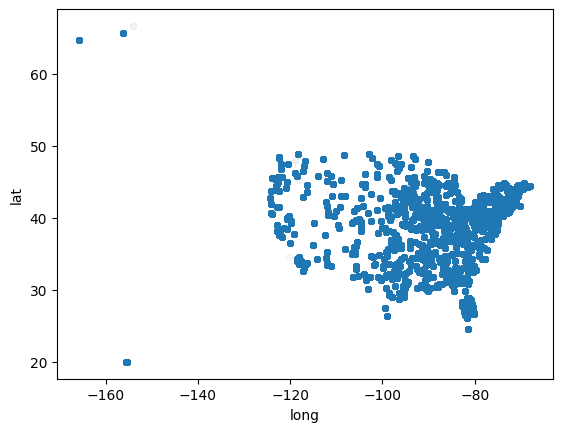

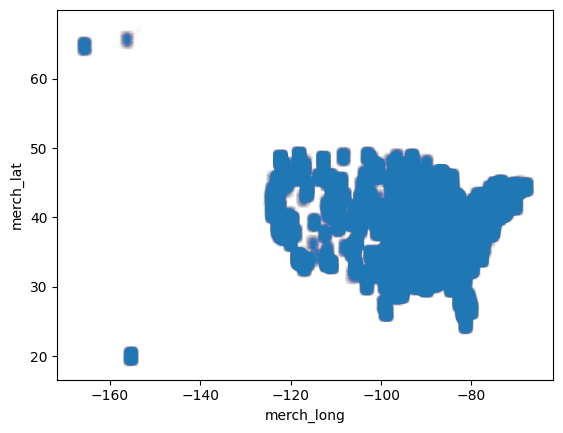

In [ ]:
transactions_encoded.plot(kind="scatter", x="long", y="lat", alpha=0.002)
transactions_encoded.plot(kind="scatter", x="merch_long", y="merch_lat", alpha=0.002)
#Both the merchants and customers seem to be around the same country/state


array([[<Axes: title={'center': 'amt'}>]], dtype=object)

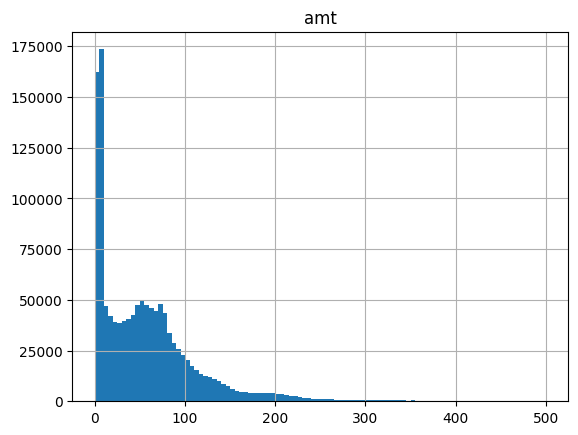

In [ ]:
transactions_encoded.hist(column="amt", range=(0, 500), bins=100)
#The usual range of the amount transacted seems to be betwwen 0 and 500

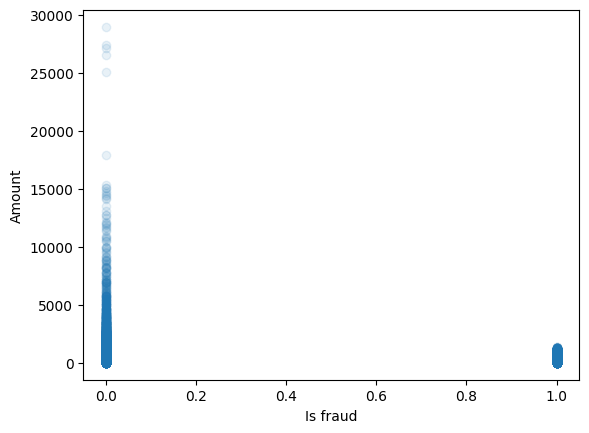

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["amt"], alpha=0.1)
plt.xlabel("Is fraud")
plt.ylabel("Amount")
plt.show()
#Contrary to what you'd expect, most frauds seem to not involve large sums of money

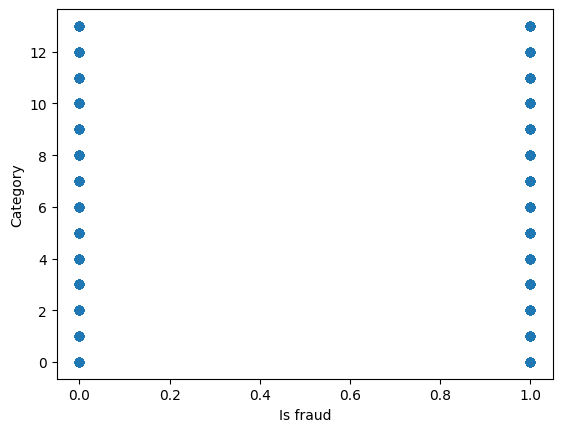

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["category"], alpha=0.1)
plt.ylabel("Category")
plt.xlabel("Is fraud")
plt.show()
#The distribution odds of fraud for each transaction category seems to be even

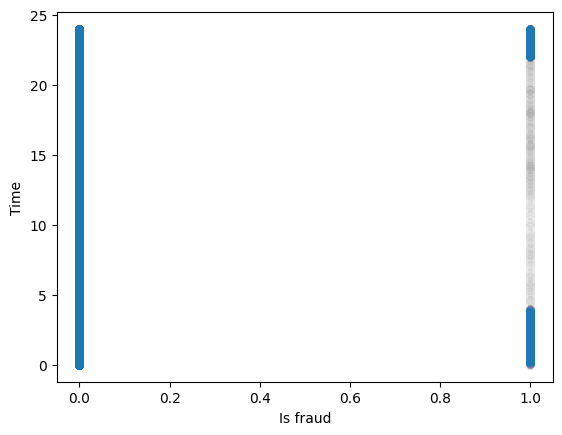

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["time"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Time")
plt.show()
#Most frauds seem to occur only between 10PM and 4AM, rather interesting

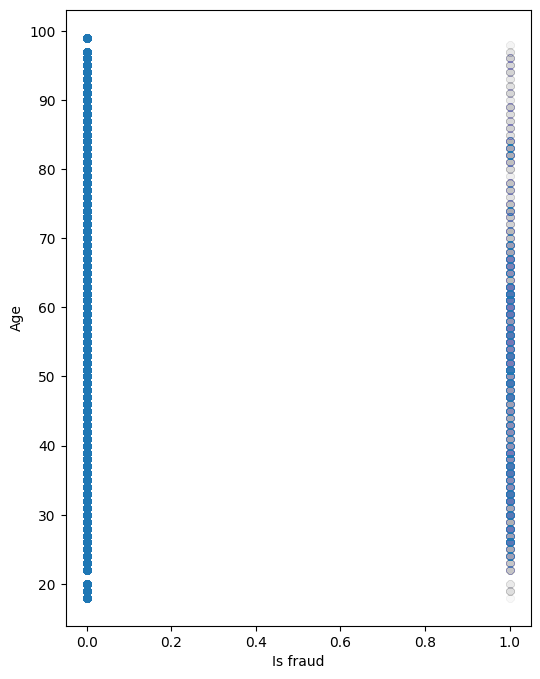

In [ ]:
plt.figure(figsize=(6, 8)) 
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["age"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Age")
plt.show()
#The age bracket within which most fraud transactions seem to fall into is 50 to 65 followed by 30 to 40, but this could also be as a result of the fact that there aren't that many people over the age of 80

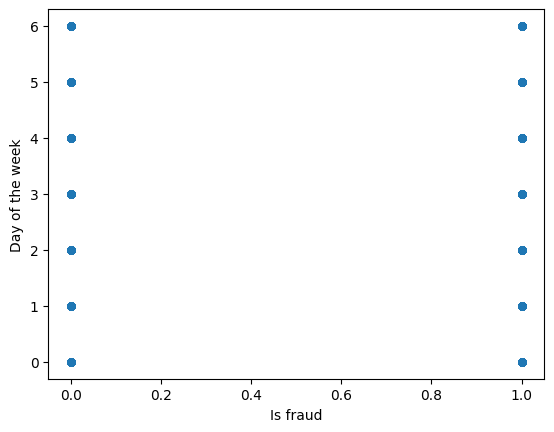

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["dow"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Day of the week")
plt.show()

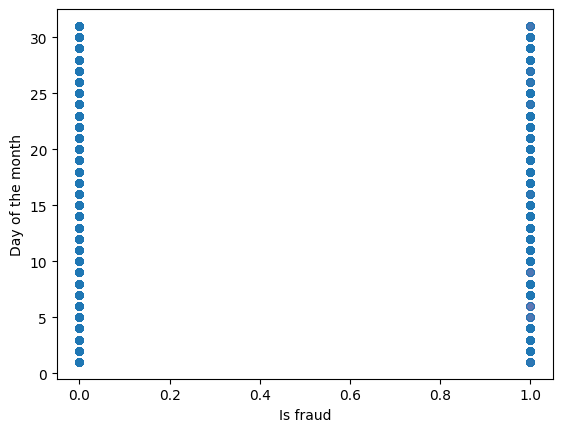

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["dom"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Day of the month")
plt.show()

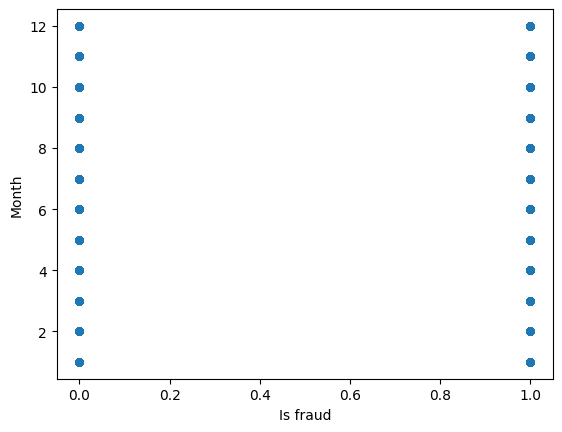

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["month"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Month")
plt.show()

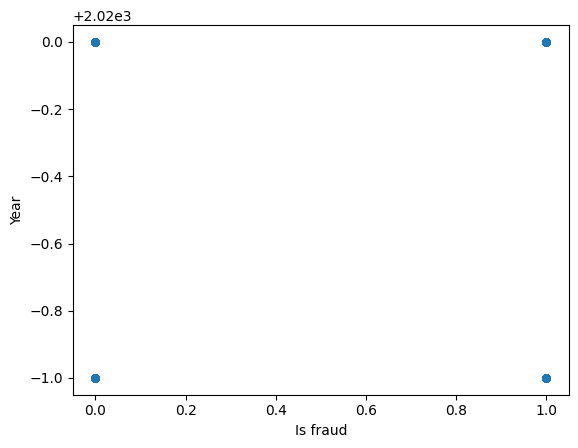

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["year"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Year")
plt.show()

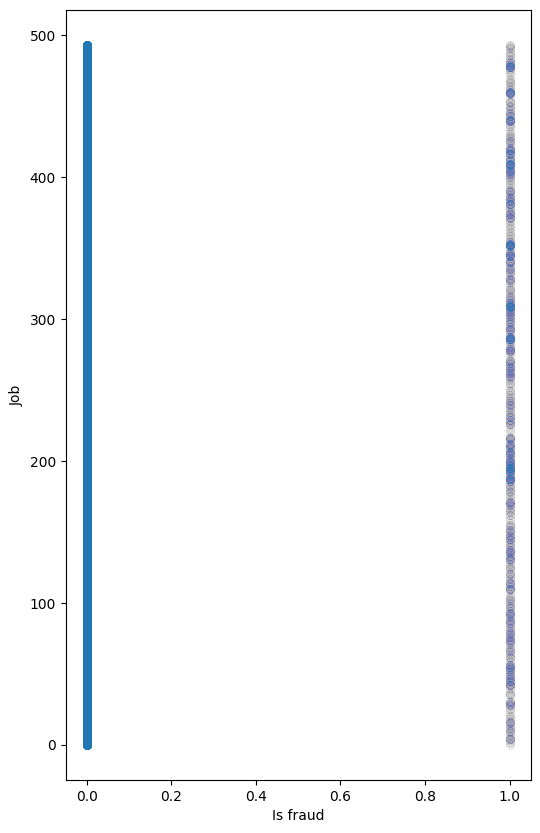

In [ ]:
plt.figure(figsize=(6, 10))
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["job"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Job")
plt.show()
#Specific jobs seem more likely to experience fraud but only to a small degree

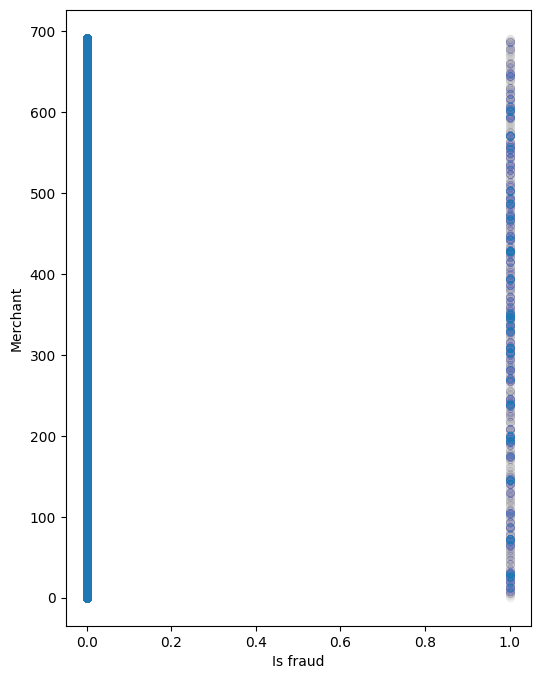

In [ ]:
plt.figure(figsize=(6, 8))
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["merch_name"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Merchant")
plt.show()
#Specific transactions with specifc merchants seem to result a bit more to frauds

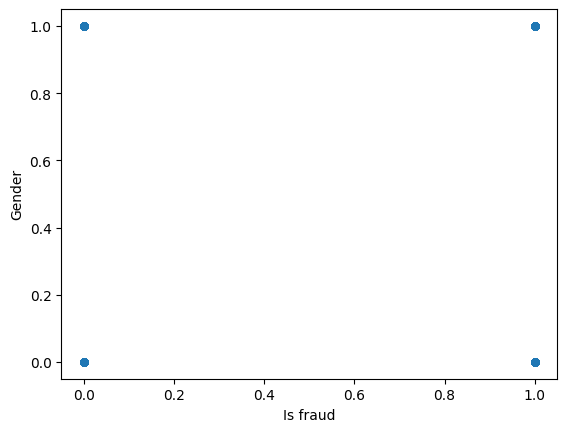

In [ ]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["gender"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Gender")
plt.show()

In [ ]:
def plot_distributions(df: pd.DataFrame, target_column: str, xlabel: str, ylabel: str, figsize: tuple, bar_color: str, intervals=True):
    target_column_count = df.groupby([target_column]).size().reset_index(name="count")
    target_column_count["percent"] = (target_column_count["count"]/target_column_count["count"].sum()*100)
    #display(target_column_count)
    plt.figure(figsize=figsize)
    plt.bar(target_column_count[target_column], target_column_count["percent"], color=bar_color)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


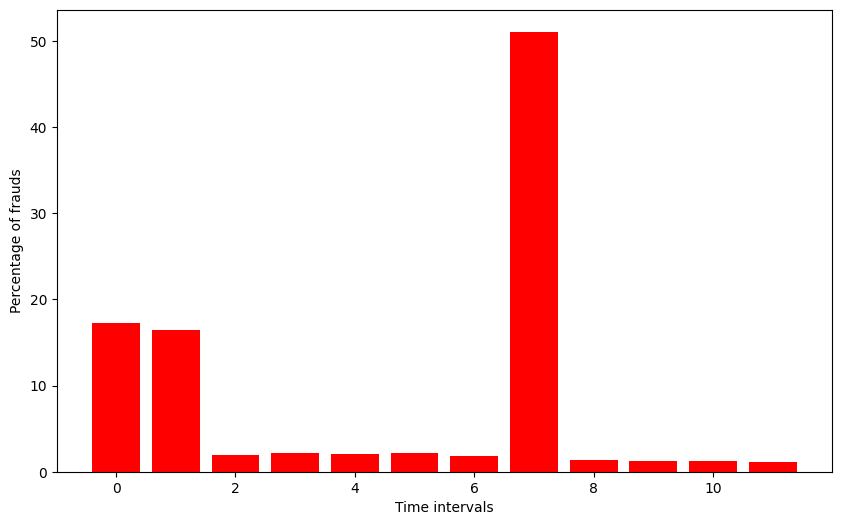

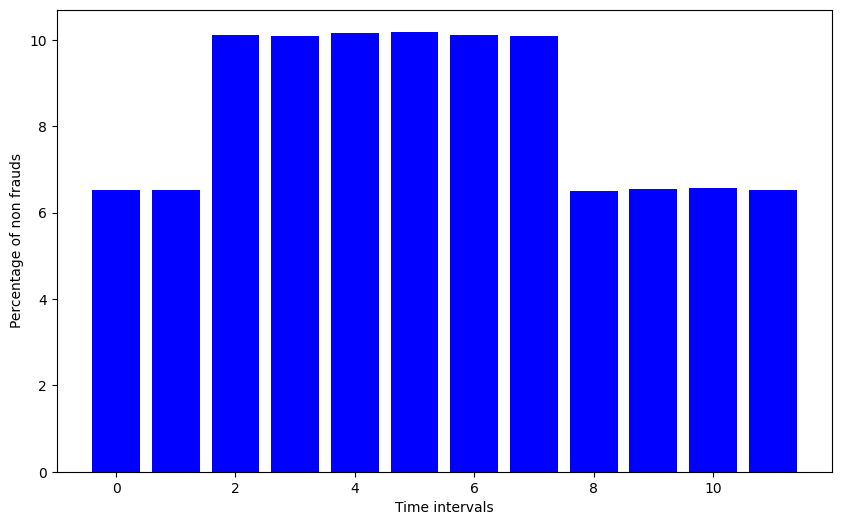

In [ ]:
fraud_transactions = transactions_encoded[transactions_encoded["is_fraud"]==1]
non_fraud_transactions = transactions_encoded[transactions_encoded["is_fraud"]==0]
plot_distributions(fraud_transactions, "time_interval", "Time intervals", "Percentage of frauds", (10, 6), "r")
plot_distributions(non_fraud_transactions, "time_interval", "Time intervals", "Percentage of non frauds", (10, 6), "b")

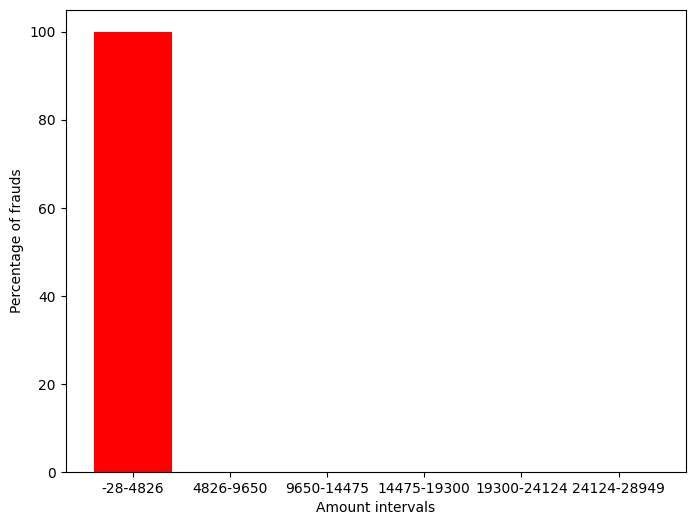

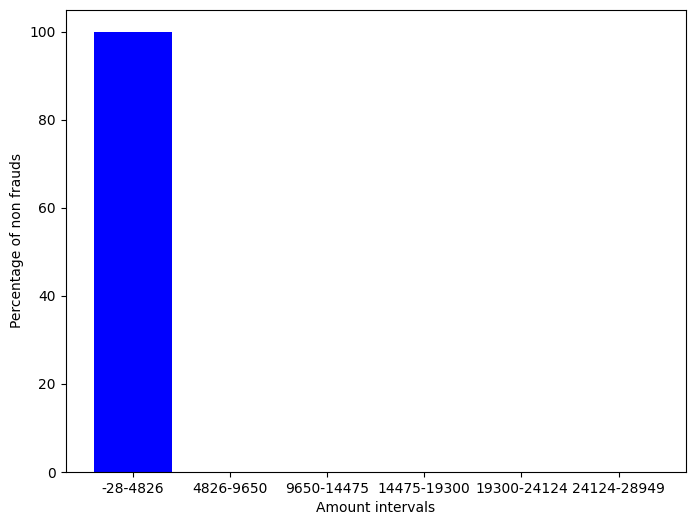

In [ ]:

plot_distributions(fraud_transactions, "amt_interval", "Amount intervals", "Percentage of frauds", (8, 6), "r")
plot_distributions(non_fraud_transactions, "amt_interval", "Amount intervals", "Percentage of non frauds", (8, 6), "b")


C:\Users\PC\AppData\Local\Temp\ipykernel_16816\145827130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions["fraud_amt_interval"] = pd.cut(fraud_transactions["amt"], bins=6)
C:\Users\PC\AppData\Local\Temp\ipykernel_16816\145827130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_transactions["non_fraud_amt_interval"] = pd.cut(non_fraud_transactions["amt"], bins=fraud_transactions["fraud_amt_interval"].cat.categories)


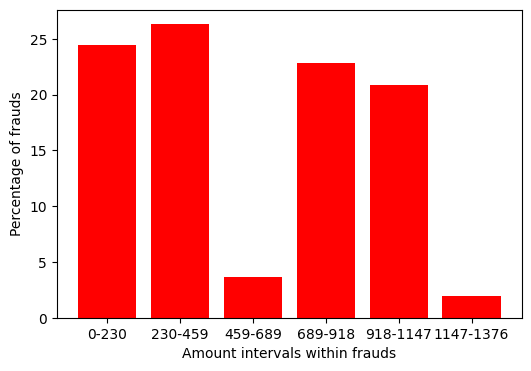

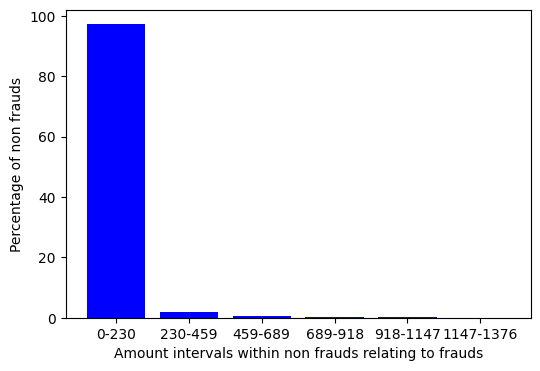

In [ ]:

fraud_transactions["fraud_amt_interval"] = pd.cut(fraud_transactions["amt"], bins=6)
                                                                                        #To use the IntervalIndex for fraud_transactions["fraud_amt_interval"]
non_fraud_transactions["non_fraud_amt_interval"] = pd.cut(non_fraud_transactions["amt"], bins=fraud_transactions["fraud_amt_interval"].cat.categories)
plot_distributions(fraud_transactions, "fraud_amt_interval", "Amount intervals within frauds", "Percentage of frauds", (6, 4), "r")
plot_distributions(non_fraud_transactions, "non_fraud_amt_interval", "Amount intervals within non frauds relating to frauds", "Percentage of non frauds", (6, 4), "b")

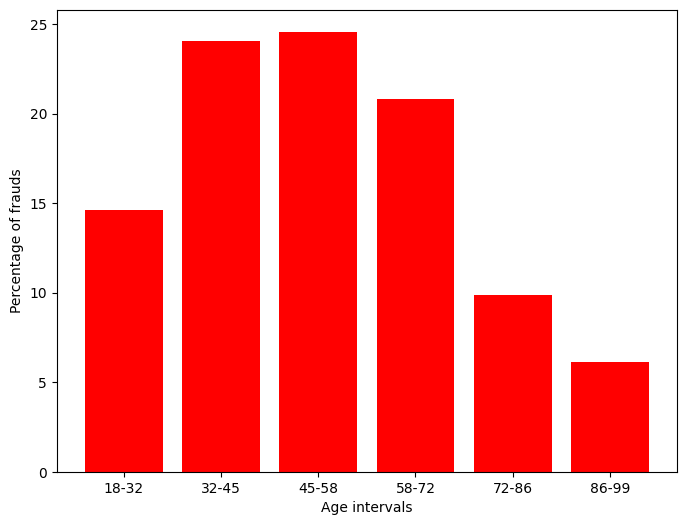

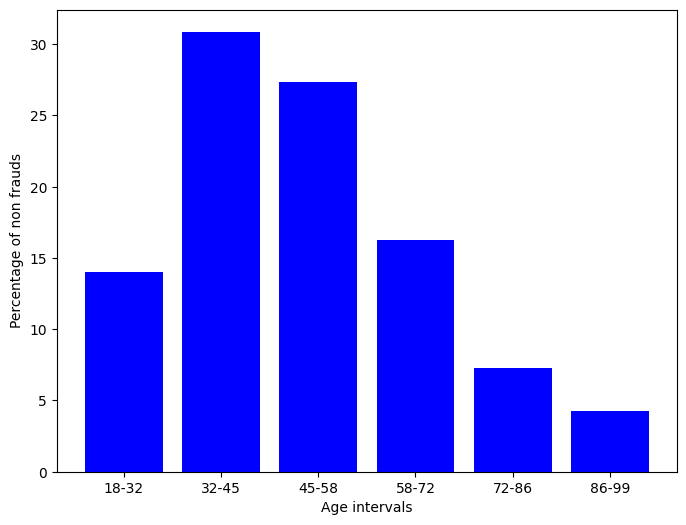

In [ ]:
plot_distributions(fraud_transactions, "age_interval", "Age intervals", "Percentage of frauds", (8, 6), "r")
plot_distributions(non_fraud_transactions, "age_interval", "Age intervals", "Percentage of non frauds", (8, 6), "b")


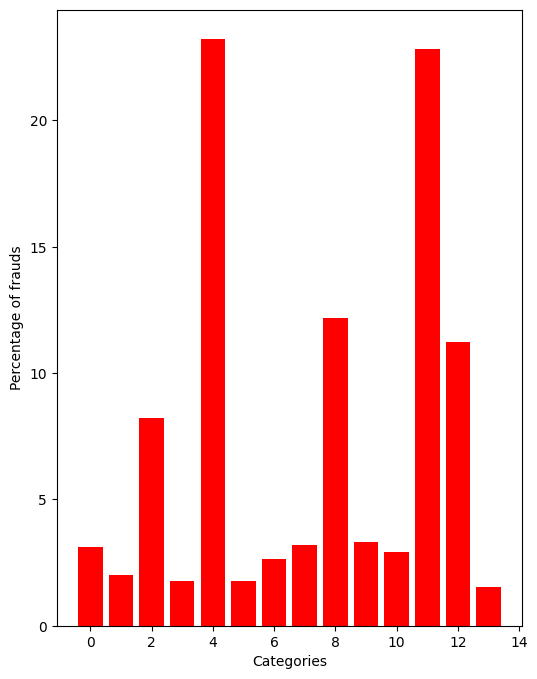

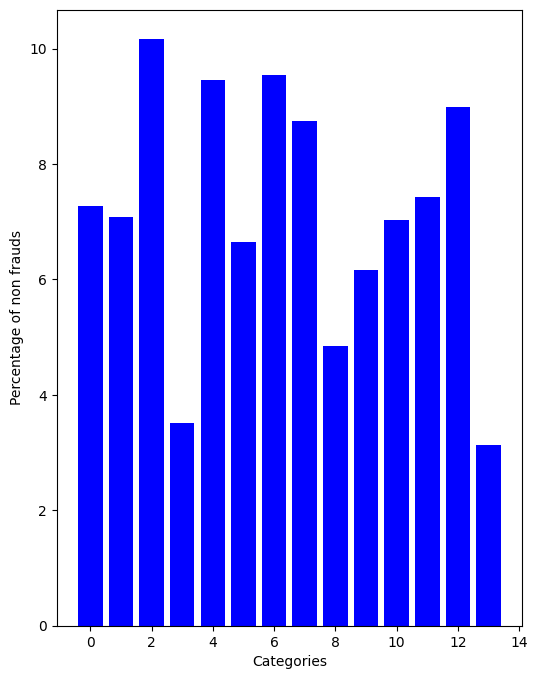

In [ ]:
plot_distributions(fraud_transactions, "category", "Categories", "Percentage of frauds", (6, 8), "r", intervals=False)
plot_distributions(non_fraud_transactions, "category", "Categories", "Percentage of non frauds", (6, 8), "b", intervals=False)

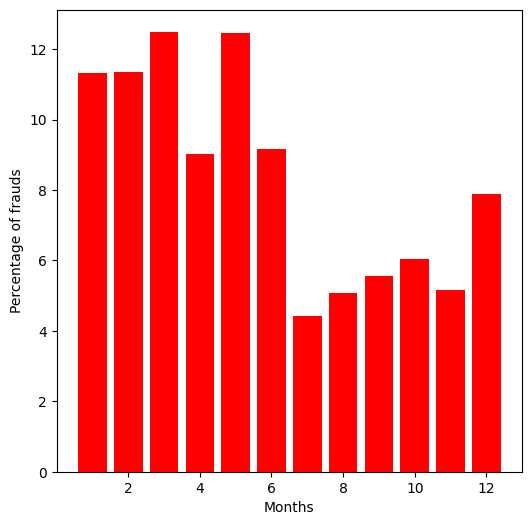

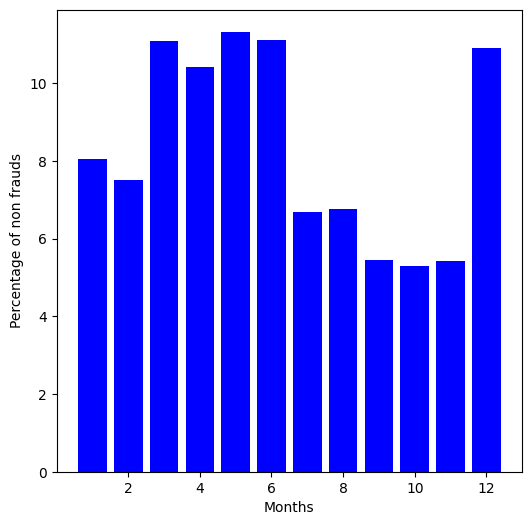

In [ ]:
plot_distributions(fraud_transactions, "month", "Months", "Percentage of frauds",(6, 6), "r", intervals=False )
plot_distributions(non_fraud_transactions, "month", "Months", "Percentage of non frauds",(6, 6), "b", intervals=False )

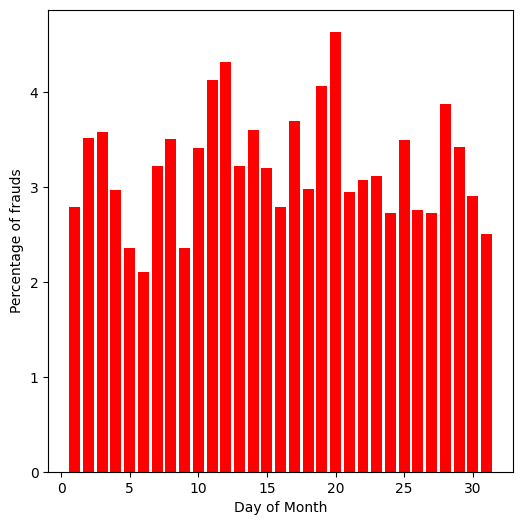

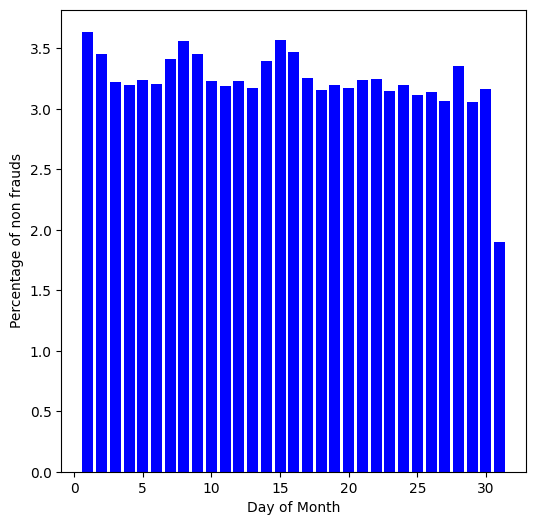

In [ ]:
plot_distributions(fraud_transactions, "dom", "Day of Month", "Percentage of frauds",(6, 6), "r", intervals=False )
plot_distributions(non_fraud_transactions, "dom", "Day of Month", "Percentage of non frauds",(6, 6), "b", intervals=False )

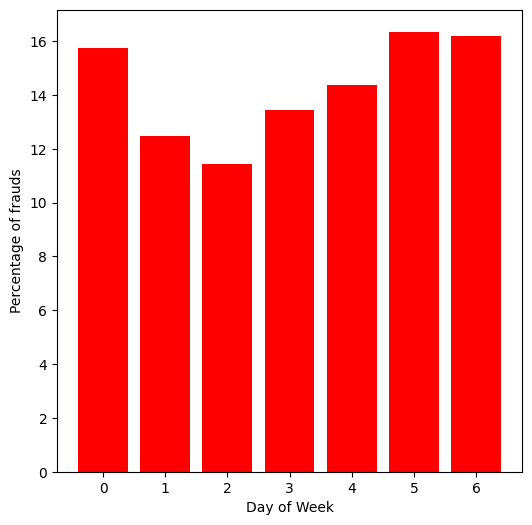

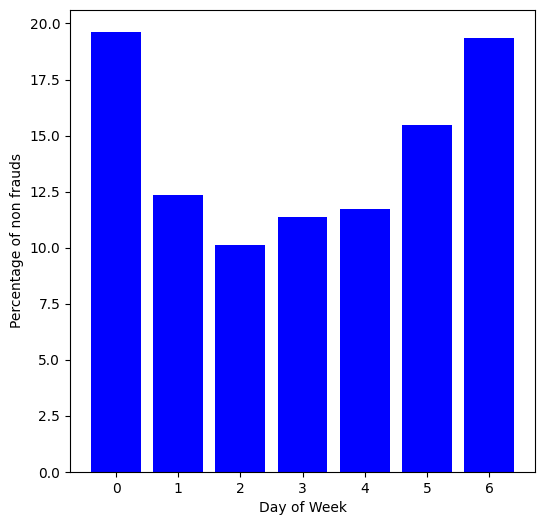

In [ ]:
plot_distributions(fraud_transactions, "dow", "Day of Week", "Percentage of frauds",(6, 6), "r", intervals=False )
plot_distributions(non_fraud_transactions, "dow", "Day of Week", "Percentage of non frauds",(6, 6), "b", intervals=False )

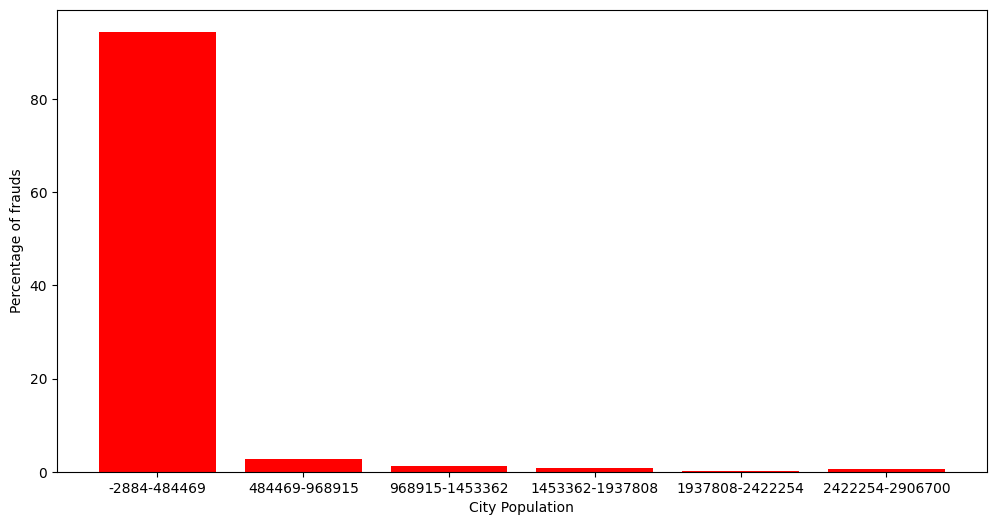

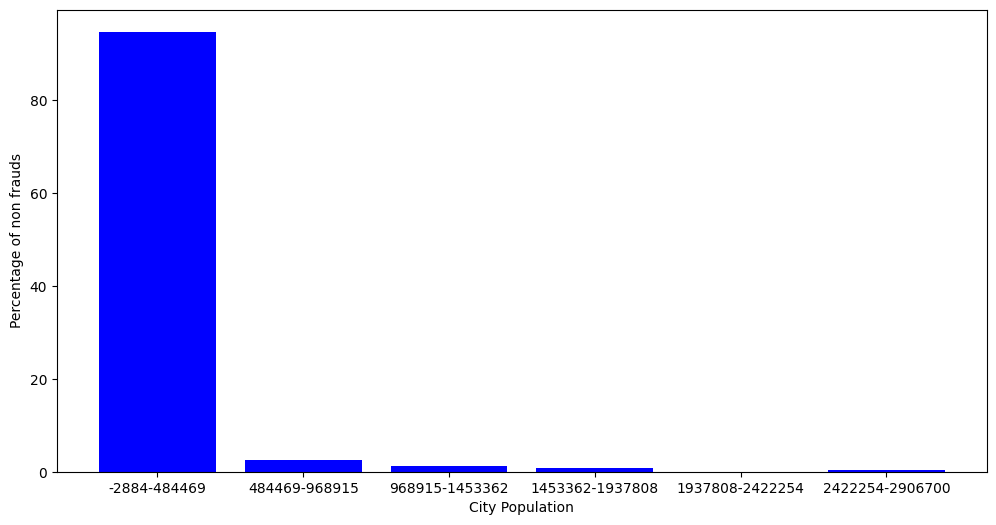

In [ ]:
plot_distributions(fraud_transactions, "city_pop_interval", "City Population", "Percentage of frauds",(12, 6), "r")
plot_distributions(non_fraud_transactions, "city_pop_interval", "City Population", "Percentage of non frauds",(12, 6), "b")

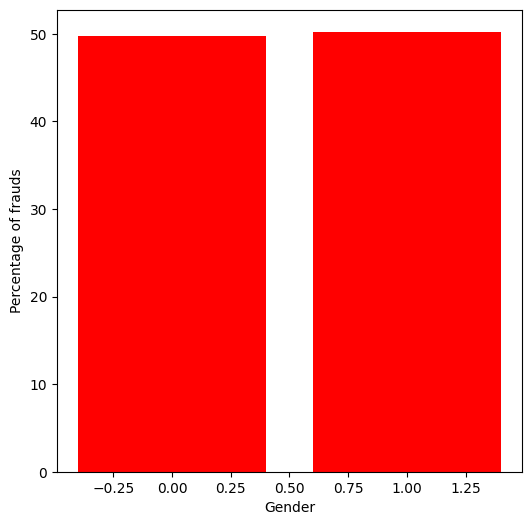

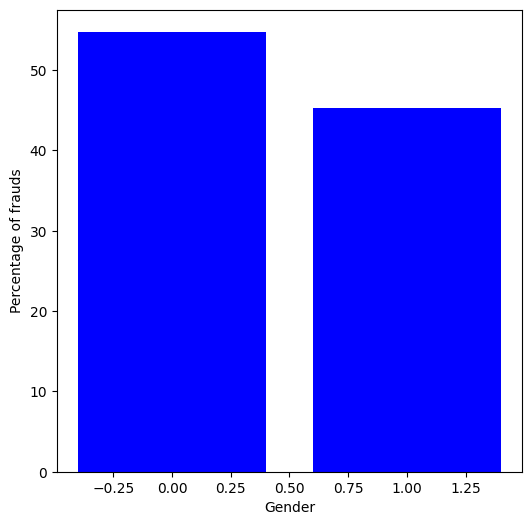

In [ ]:
plot_distributions(fraud_transactions, "gender", "Gender", "Percentage of frauds", (6, 6), "r", intervals=False)
plot_distributions(non_fraud_transactions, "gender", "Gender", "Percentage of frauds", (6, 6), "b", intervals=False)

<Axes: xlabel='long', ylabel='lat'>

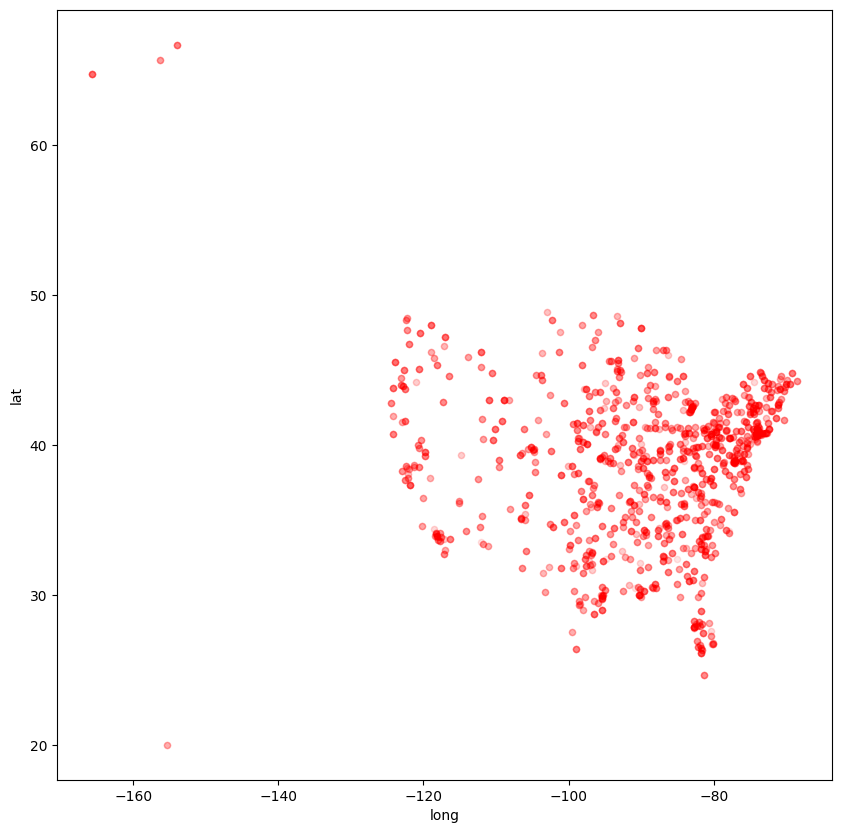

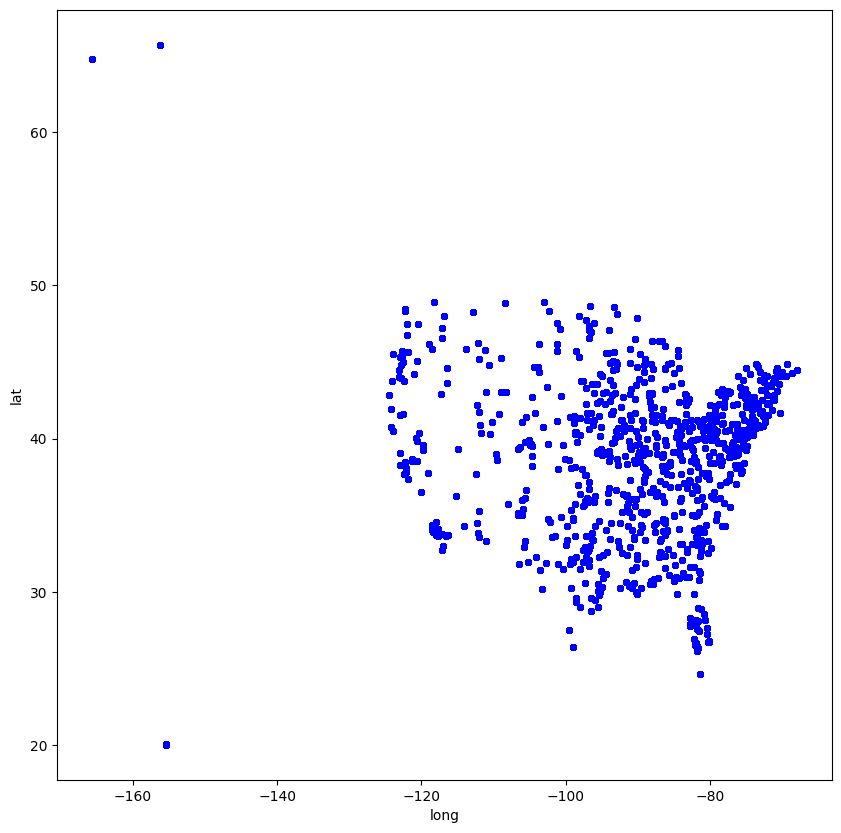

In [ ]:
fraud_transactions.plot(kind="scatter", x="long", y="lat", alpha=0.05, figsize=(10, 10), color="r")
non_fraud_transactions.plot(kind="scatter", x="long", y="lat", alpha=0.002, figsize=(10, 10), color="b")
#transactions_encoded.plot(kind="scatter", x="long", y="lat", alpha=0.002, figsize=(10, 10), colormap="hot", c=transactions_encoded["is_fraud"])

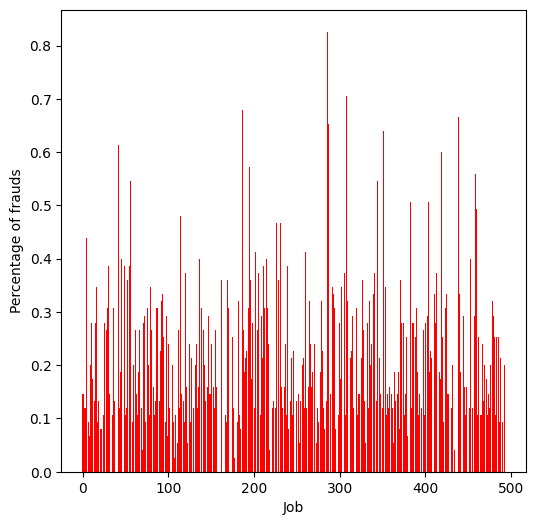

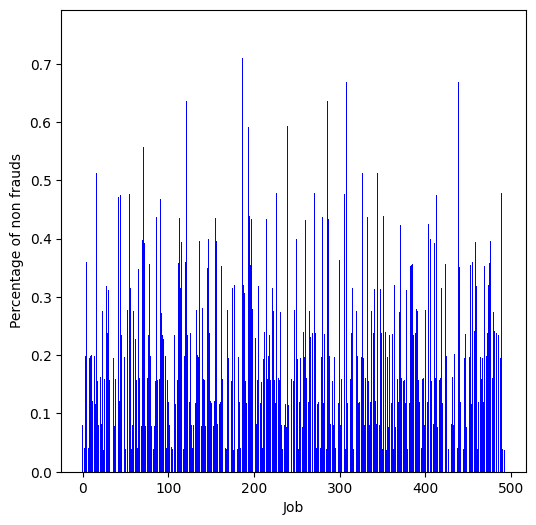

In [ ]:
plot_distributions(fraud_transactions, "job", "Job", "Percentage of frauds", (6, 6), "r", intervals=False)
plot_distributions(non_fraud_transactions, "job", "Job", "Percentage of non frauds", (6, 6), "b", intervals=False)

In [ ]:
#Split train and test set
def split_train_test(df: pd.DataFrame, target_class: str)->tuple[pd.DataFrame, pd.DataFrame]:
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)
    for train_set, test_set in split.split(df, df[target_class]):
        strat_train_set = df.loc[train_set]
        strat_test_set = df.loc[test_set]
    return strat_train_set, strat_test_set

In [213]:
train_set, test_set = split_train_test(transactions_encoded, "is_fraud")
x_train, y_train, x_test, y_test = train_set.drop("is_fraud", axis=1), train_set["is_fraud"], test_set.drop("is_fraud", axis=1), test_set["is_fraud"] 
display((len(y_train[y_train==1])/len(x_train))*100)
display((len(y_test[y_test==1])/len(x_test))*100)

0.578884454470087

0.5787880540613491

In [524]:
def select_features(df: pd.DataFrame, features: list[str])->pd.DataFrame:
    copy = df.copy()
    for feat in df.columns:
        if feat not in features:
            copy = copy.drop(feat, axis=1)
    return copy

display(x_train)

from sklearn.compose import ColumnTransformer
def one_hot_encode(df: pd.DataFrame, features: list[str])->pd.DataFrame:
    copy = df.copy()
    preprocessor = ColumnTransformer(
        transformers=[("encoder", preprocessing.OneHotEncoder(), features)],
        remainder="passthrough"
    )
    prefix = "remainder__"
    encoded = preprocessor.fit_transform(copy)
    new_names = preprocessor.get_feature_names_out(df.columns)
    for idx, name in enumerate(new_names):
        if name.startswith(prefix):
            new_names[idx] = name[len(prefix):]

    df_encoded = pd.DataFrame(encoded, columns=new_names)
    return df_encoded
x_train_selected = select_features(x_train, ["amt", "category", "time", "city_pop", "age", "gender", "month"])
display(x_train_selected)

,full_name,gender,age,age_interval,job,lat,long,city_pop,city_pop_interval,merch_name,...,merch_long,amt,amt_interval,category,time,time_interval,dow,dom,month,year
606112,295,1,34,1,238,35.7206,-108.0271,5662,0,213,...,-108.148243,58.86,0,6,21.683333,6,5,14,9,2019
945398,378,1,54,2,344,39.4015,-75.8654,663,0,34,...,-76.283767,1.80,0,1,23.533333,7,6,12,1,2020
362837,252,1,39,1,299,38.8954,-77.1633,207410,0,69,...,-78.105580,114.85,0,6,14.450000,3,0,17,6,2019
679791,611,0,33,1,102,41.8467,-74.1038,722,0,280,...,-75.068677,22.48,0,3,2.533333,1,3,17,10,2019
1176541,874,1,41,1,287,37.1935,-89.0933,639,0,376,...,-88.658783,71.71,0,0,21.050000,6,1,5,5,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045281,354,1,39,1,381,26.9379,-82.2388,79008,0,552,...,-82.157986,10.08,0,6,15.600000,3,0,9,3,2020
765044,664,0,29,0,239,43.2237,-75.1612,1684,0,89,...,-74.977981,39.19,0,6,22.733333,7,5,23,11,2019
924938,25,0,38,1,327,26.4722,-81.8122,224256,0,533,...,-81.975625,213.26,0,4,2.133333,1,2,1,1,2020
1082703,965,1,29,0,222,30.4590,-90.9027,71335,0,665,...,-90.143937,53.72,0,10,14.416667,3,2,25,3,2020


,gender,age,city_pop,amt,category,time,month
606112,1,34,5662,58.86,6,21.683333,9
945398,1,54,663,1.80,1,23.533333,1
362837,1,39,207410,114.85,6,14.450000,6
679791,0,33,722,22.48,3,2.533333,10
1176541,1,41,639,71.71,0,21.050000,5
...,...,...,...,...,...,...,...
1045281,1,39,79008,10.08,6,15.600000,3
765044,0,29,1684,39.19,6,22.733333,11
924938,0,38,224256,213.26,4,2.133333,1
1082703,1,29,71335,53.72,10,14.416667,3


In [540]:
def generate_confusion_matrix(model, x, y, cv: str)->list[list[int]]:
    return metrics.confusion_matrix(y_train, model_selection.cross_val_predict(model, x, y, cv=cv))

def display_confusion_matrix(confusion_matrix: list[list[int]], non_fraud, fraud):
    nonfraud_count = len(non_fraud)
    fraud_count = len(fraud)
    print(confusion_matrix)
    print("\nPredictions non-fraud  fraud\n")
    true_positive_non_fraud = round(confusion_matrix[0][0]/nonfraud_count*100, 2)
    false_positive_non_fraud = round(confusion_matrix[0][1]/nonfraud_count*100, 2)
    true_positive_fraud = round(confusion_matrix[1][0]/fraud_count*100, 2)
    false_positive_fraud = round(confusion_matrix[1][1]/fraud_count*100, 2)
    print(f"Non fraud   {true_positive_non_fraud}%     {false_positive_non_fraud}%\n")
    print(f"Fraud       {true_positive_fraud}%     {false_positive_fraud}%")

In [548]:
tree = DecisionTreeClassifier(random_state=69)

non_fraud_train = train_set[train_set["is_fraud"]==0]
fraud_train = train_set[train_set["is_fraud"]==1]
display_confusion_matrix(generate_confusion_matrix(tree, x_train_selected, y_train, 5),  non_fraud_train, fraud_train)

[[1030118    1217]
 [   1058    4947]]

Predictions non-fraud  fraud

Non fraud   99.88%     0.12%

Fraud       17.62%     82.38%


In [551]:
tree.fit(x_train_selected, y_train)

DecisionTreeClassifier(random_state=69)

In [553]:
x_test_selected = select_features(x_test, ["amt", "category", "time", "city_pop", "age", "gender", "month"])

non_fraud_test = test_set[test_set["is_fraud"]==0]
fraud_test = test_set[test_set["is_fraud"]==1]
display_confusion_matrix(metrics.confusion_matrix(y_test, tree.predict(x_test_selected)), non_fraud_test, fraud_test)

[[257549    285]
 [   257   1244]]

Predictions non-fraud  fraud

Non fraud   99.89%     0.11%

Fraud       17.12%     82.88%


In [554]:
features = list(x_train_selected.columns)
joblib.dump(value=(tree, features, "is_fraud"), filename="./model.pkl")

['./model.pkl']

In [556]:
model, test_feat, test_target = joblib.load("./model.pkl")
display(test_feat)
display(test_target)
display(model)
display_confusion_matrix(metrics.confusion_matrix(y_test, model.predict(x_test_selected)), non_fraud_test, fraud_test)

['gender', 'age', 'city_pop', 'amt', 'category', 'time', 'month']

'is_fraud'

DecisionTreeClassifier(random_state=69)

[[257549    285]
 [   257   1244]]

Predictions non-fraud  fraud

Non fraud   99.89%     0.11%

Fraud       17.12%     82.88%
